# Pipeline for analyzing flow cytometry data

In [1]:
from FlowCytometryTools import *
import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
import glob
import seaborn as sns

import os
import sys

path = '/Users/andrewng/Documents/AHN_FlowTools/'
if not path in sys.path:
    sys.path.insert(1, path)
del path

from AHN_FlowTools import *

sns.set_style('white')
sns.set_style('ticks')
%matplotlib inline

In [2]:
datadir = list()

datadir.append('/Users/andrewng/Documents/HES Lab/Flow Cytometry/2018LOCKRPaper/ahn20180510_LOCKRtunetrip/Plate1/')
datadir.append('/Users/andrewng/Documents/HES Lab/Flow Cytometry/2018LOCKRPaper/ahn20180510_LOCKRtunetrip/Plate2/')
datadir.append('/Users/andrewng/Documents/HES Lab/Flow Cytometry/2018LOCKRPaper/ahn20180510_LOCKRtunetrip/Plate3/')
datadir.append('/Users/andrewng/Documents/HES Lab/Flow Cytometry/2018LOCKRPaper/ahn20180510_LOCKRtunetrip/Plate4/')
datadir.append('/Users/andrewng/Documents/HES Lab/Flow Cytometry/2018LOCKRPaper/ahn20180510_LOCKRtunetrip/Plate5/')
datadir.append('/Users/andrewng/Documents/HES Lab/Flow Cytometry/2018LOCKRPaper/ahn20180510_LOCKRtunetrip/Plate6/')
datadir.append('/Users/andrewng/Documents/HES Lab/Flow Cytometry/2018LOCKRPaper/ahn20180510_LOCKRtunetrip/Plate7/')

datadir.append('/Users/andrewng/Documents/HES Lab/Flow Cytometry/ahn20190124_LOCKRrepeats/yAHN851_1/')
datadir.append('/Users/andrewng/Documents/HES Lab/Flow Cytometry/ahn20190124_LOCKRrepeats/yAHN851_2/')
datadir.append('/Users/andrewng/Documents/HES Lab/Flow Cytometry/ahn20190124_LOCKRrepeats/yAHN851_3/')

date = '20180510'

allfiles = {}
strains = ['Plate1','Plate2','Plate3','Plate4','Plate5','Plate6','Plate7','yAHN851_1','yAHN851_2','yAHN851_3']

for i in range(len(datadir)):
    files = glob.glob(datadir[i] + '*.fcs')
    allfiles[strains[i]] = files

In [3]:
rows = ['A','B','C','D','E','F','G','H']
cols = ['01','02','03','04','05','06','07','08','09','10','11','12']

In [4]:
plateraw = pd.DataFrame(index = rows, columns = cols)

panelDict = {strain:plateraw for strain in strains}
allplates = pd.Panel(panelDict)

/Users/andrewng/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2878: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
for strain in strains:
    for f in allfiles[strain]:
        c = f[-10:-8]
        r = f[-11]
        call = r + c
        allplates[strain].set_value(r, c, FCMeasurement(ID = call, datafile = f))

/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [6]:
def FCdatastats(platesort,normalized=None,rows=None,cols=None,FITCthresh=None,FSCthresh=None):

    #Calculate the linear median, mean, and SD for each of the wells. Create two different Panels, one for FITC and one
    #for mCherry. In each Panel store a DataFrame containing the median, mean, SD, and CV

    if normalized is None:
        normalized = True
    if rows is None:
        rows = ['A','B','C','D','E','F','G','H']
    if cols is None:
        cols = ['01','02','03','04','05','06','07','08','09','10','11','12']
    if FITCthresh is None:
        FITCthresh = 100
    if FSCthresh is None:
        FSCthresh = 1000

    empty = pd.DataFrame(index = rows, columns = cols)

    FITCstats = pd.Panel({'raw':empty, 'med':empty, 'avg':empty, 'sd':empty, 'cv':empty})
    RFPstats = pd.Panel({'raw':empty, 'med':empty, 'avg':empty, 'sd':empty,'cv':empty})
    BFPstats = pd.Panel({'raw':empty, 'med':empty, 'avg':empty, 'sd':empty,'cv':empty})
    CFPstats = pd.Panel({'raw':empty, 'med':empty, 'avg':empty, 'sd':empty,'cv':empty})

    for row in rows:
        for col in cols:

            try:
                FCM = gate(platesort.loc[row,col],'FITC-H',FITCthresh)

                FCM2 = FCM[FCM['SSC-H'] > FSCthresh]
            except TypeError:
                continue

            try:
                if normalized == True:
                    FITC = FCM2['FITC-H']/FCM2['SSC-H']
                    RFP = FCM2['PE-Texas Red-H']/FCM2['SSC-H']
                    BFP = FCM2['DAPI-H']/FCM2['SSC-H']
                    CFP = FCM2['AmCyan-H']/FCM2['SSC-H']

                elif normalized == False:
                    FITC = FCM2['FITC-H']
                    RFP = FCM2['PE-Texas Red-H']
                    BFP = FCM2['DAPI-H']
                    CFP = FCM2['AmCyan-H']

                FITCstats.raw.set_value(row, col, FITC)
                FITCstats.med.set_value(row,col,FITC.median(axis=0))
                FITCstats.avg.set_value(row,col,FITC.mean(axis=0))
                FITCstats.sd.set_value(row,col,FITC.std(axis=0))
                FITCstats.cv.set_value(row,col,FITCstats.avg.loc[row,col]/FITCstats.sd.loc[row,col])

                RFPstats.raw.set_value(row, col, RFP)
                RFPstats.med.set_value(row,col,RFP.median(axis=0))
                RFPstats.avg.set_value(row,col,RFP.mean(axis=0))
                RFPstats.sd.set_value(row,col,RFP.std(axis=0))
                RFPstats.cv.set_value(row,col,RFPstats.avg.loc[row,col]/RFPstats.sd.loc[row,col])

                BFPstats.raw.set_value(row, col, BFP)
                BFPstats.med.set_value(row,col,BFP.median(axis=0))
                BFPstats.avg.set_value(row,col,BFP.mean(axis=0))
                BFPstats.sd.set_value(row,col,BFP.std(axis=0))
                BFPstats.cv.set_value(row,col,BFPstats.avg.loc[row,col]/BFPstats.sd.loc[row,col])
                
                CFPstats.raw.set_value(row, col, CFP)
                CFPstats.med.set_value(row,col,CFP.median(axis=0))
                CFPstats.avg.set_value(row,col,CFP.mean(axis=0))
                CFPstats.sd.set_value(row,col,CFP.std(axis=0))
                CFPstats.cv.set_value(row,col,CFPstats.avg.loc[row,col]/CFPstats.sd.loc[row,col])
                
            except (AttributeError, TypeError):
                continue

    return [FITCstats, RFPstats, BFPstats, CFPstats]

In [7]:
FITCnorm = {}
RFPnorm = {}
BFPnorm = {}
CFPnorm = {}

for strain in strains: 
    [FITCnorm[strain], RFPnorm[strain],BFPnorm[strain],CFPnorm[strain]] = FCdatastats(allplates[strain],1,rows,cols,10,1000)

/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  import sys
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:47: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:48: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:49: FutureWarning: set_value is deprecated and wil

In [8]:
#Define the rows

Econcind = range(8)
Pconcind = range(12)
P2concind = range(12)

Econc = list()
Pconc = list()
P2conc = list()

for j in range(7):
    Econc.append('{0:.2f}'.format(round(50*0.5**j,2)))

for i in range(11):
    Pconc.append('{0:.2f}'.format(round(200*0.5**i,2)))
    P2conc.append('{0:.2f}'.format(round(100*0.5**i,2)))

Px = [round(200*0.5**i,2) for i in range(11)]
P2x = [round(100*0.5**i,2) for i in range(11)]

Econc.append(0)
Pconc.append(0)
P2conc.append(0)

Px.append(0)
P2x.append(0)

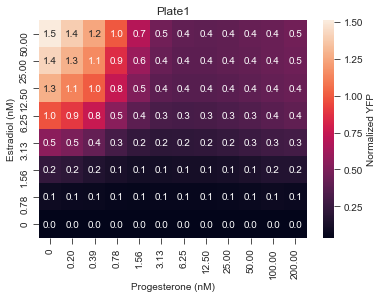

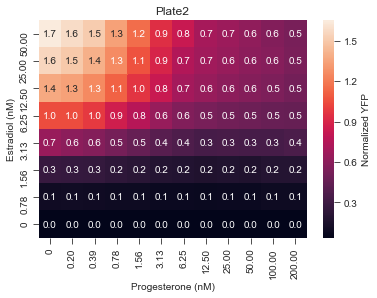

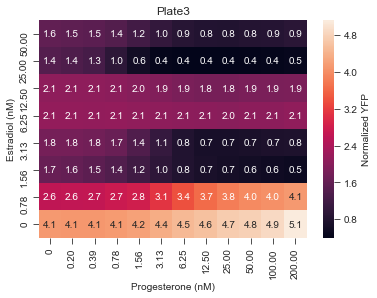

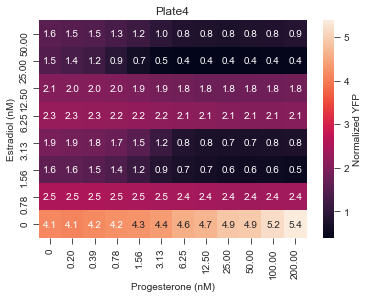

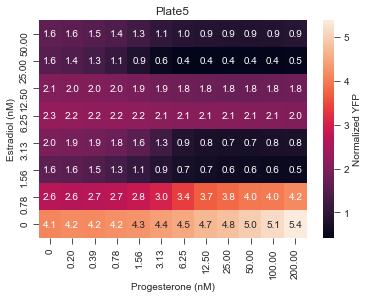

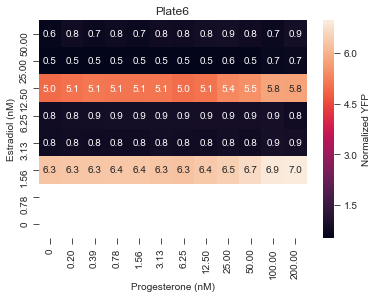

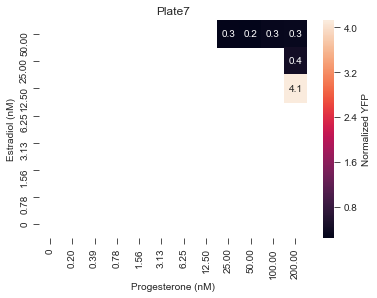

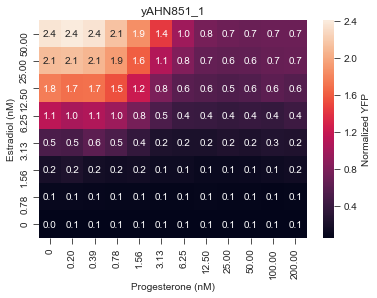

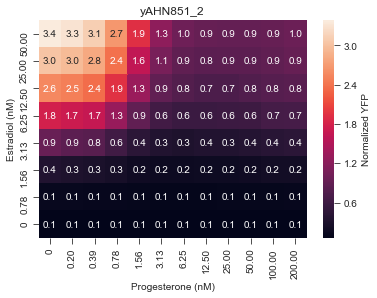

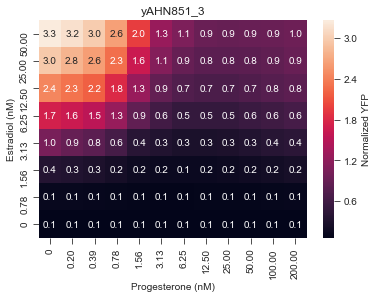

In [9]:
for plate in strains:
    sns.heatmap(FITCnorm[plate].avg.iloc[:,::-1].astype(float),xticklabels = Pconc[::-1],yticklabels = Econc,annot=True,fmt='.1f',cbar_kws={'label': 'Normalized YFP'})
    plt.title(plate)
    plt.xlabel('Progesterone (nM)')
    plt.ylabel('Estradiol (nM)')

    dest = date + plate + 'YFPheatmap'
    plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
    plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()

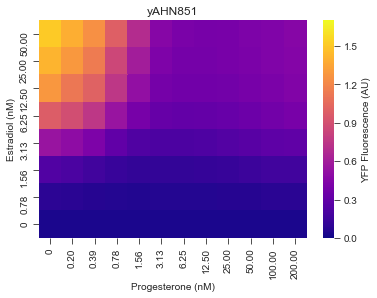

In [10]:
plt.subplots()
sns.heatmap(FITCnorm['Plate1'].avg.iloc[:,::-1].astype(float),vmin= 0, vmax = 1.7, xticklabels = Pconc[::-1],yticklabels = Econc,fmt='.1f',cmap = 'plasma',cbar_kws={'label': 'YFP Fluorescence (AU)'})
plt.title('yAHN851')
plt.xlabel('Progesterone (nM)')
plt.ylabel('Estradiol (nM)')

dest = date + 'yAHN851YFPheatmapnonorm'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
plt.show()
plt.close()

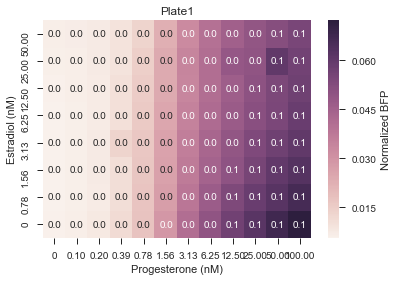

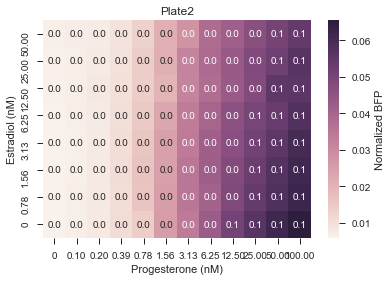

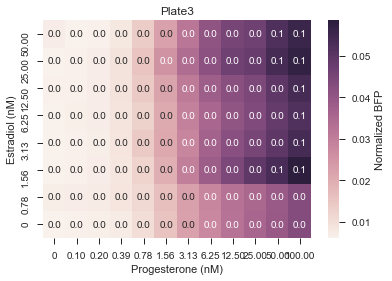

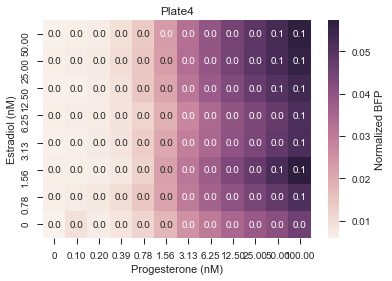

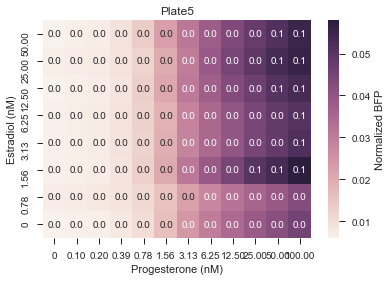

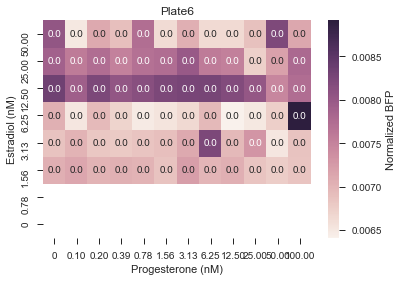

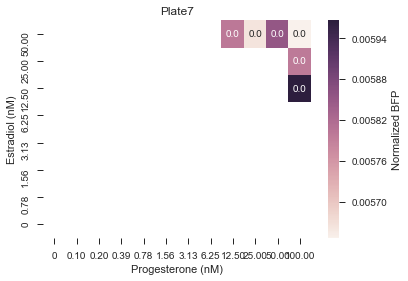

In [23]:
for plate in strains:
    sns.heatmap(BFPnorm[plate].avg.iloc[:,::-1].astype(float),xticklabels = Pconc[::-1],yticklabels = Econc,annot=True,fmt='.1f',cbar_kws={'label': 'Normalized BFP'})
    plt.title(plate)
    plt.xlabel('Progesterone (nM)')
    plt.ylabel('Estradiol (nM)')

    dest = date + plate + 'BFPheatmap'
    plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
    plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()

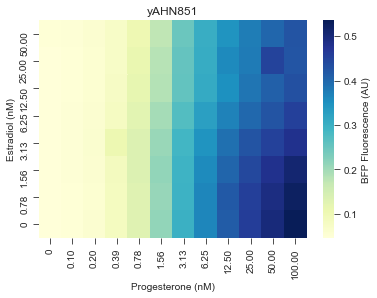

In [10]:
sns.heatmap(BFPnorm['Plate1'].avg.iloc[:,::-1].astype(float),xticklabels = Pconc[::-1],yticklabels = Econc,fmt='.1f',cmap = 'YlGnBu',cbar_kws={'label': 'BFP Fluorescence (AU)'})
plt.title('yAHN851')
plt.xlabel('Progesterone (nM)')
plt.ylabel('Estradiol (nM)')

dest = date + 'yAHN851BFPheatmapnonorm'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
plt.show()
plt.close()

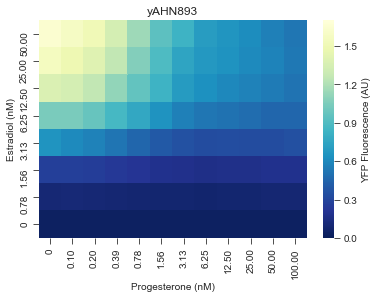

In [15]:
plt.subplots()
sns.heatmap(FITCnorm['Plate2'].avg.iloc[:,::-1].astype(float),vmin= 0, vmax = 1.7,xticklabels = Pconc[::-1],yticklabels = Econc,fmt='.1f',cmap = 'YlGnBu_r',cbar_kws={'label': 'YFP Fluorescence (AU)'}, )
plt.title('yAHN893')
plt.xlabel('Progesterone (nM)')
plt.ylabel('Estradiol (nM)')

dest = date + 'yAHN893YFPheatmapnonorm'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
plt.show()
plt.close()

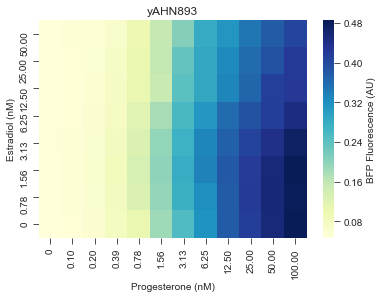

In [12]:
sns.heatmap(BFPnorm['Plate2'].avg.iloc[:,::-1].astype(float),xticklabels = Pconc[::-1],yticklabels = Econc,fmt='.1f',cmap = 'YlGnBu',cbar_kws={'label': 'BFP Fluorescence (AU)'})
plt.title('yAHN893')
plt.xlabel('Progesterone (nM)')
plt.ylabel('Estradiol (nM)')

dest = date + 'yAHN893BFPheatmapnonorm'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
plt.show()
plt.close()

## Work up histograms of the data in a 96 well plate format

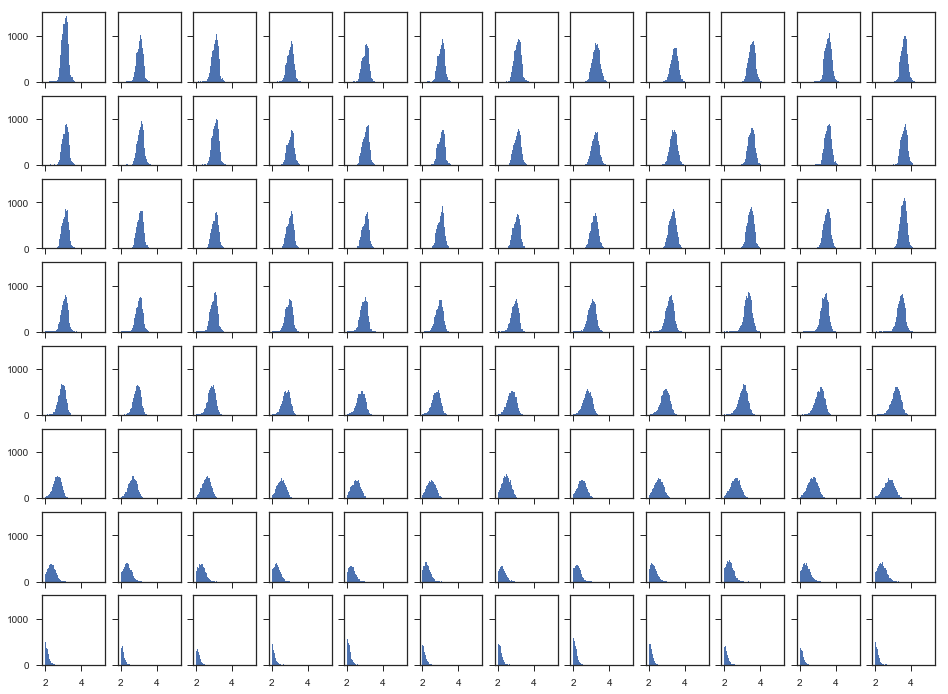

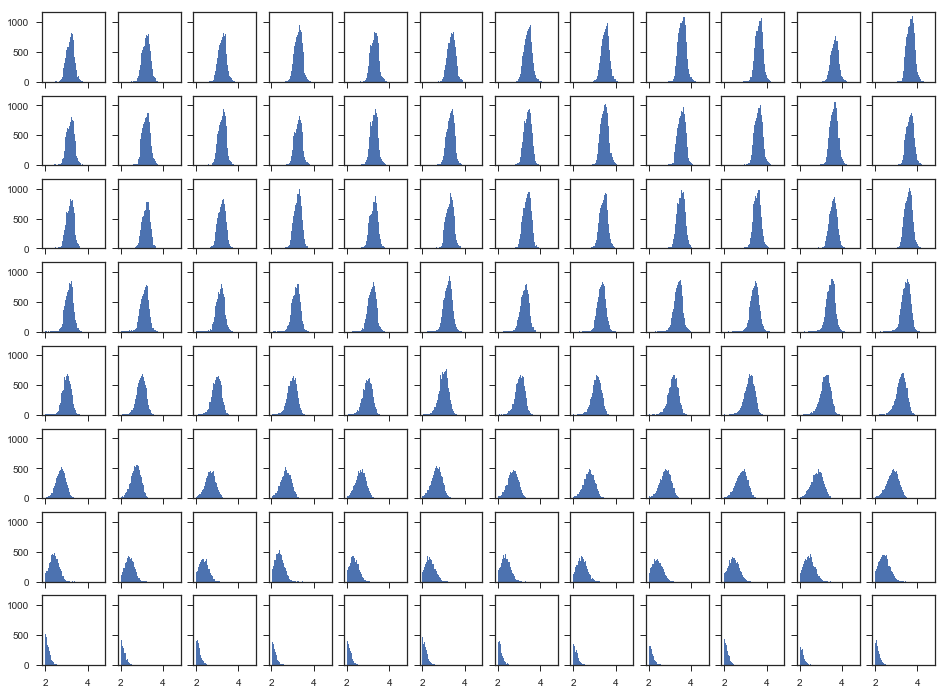

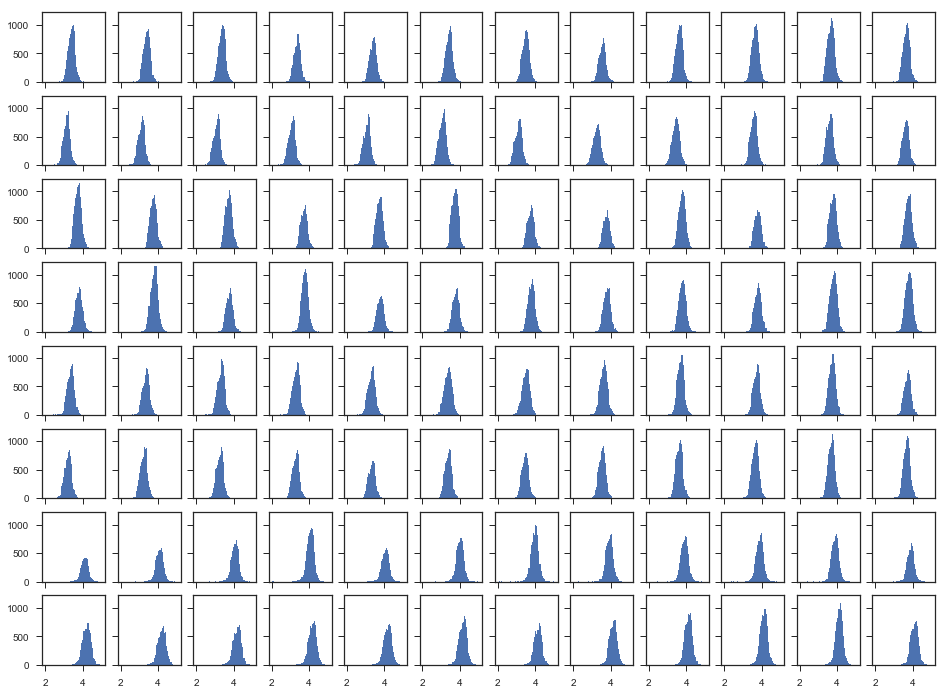

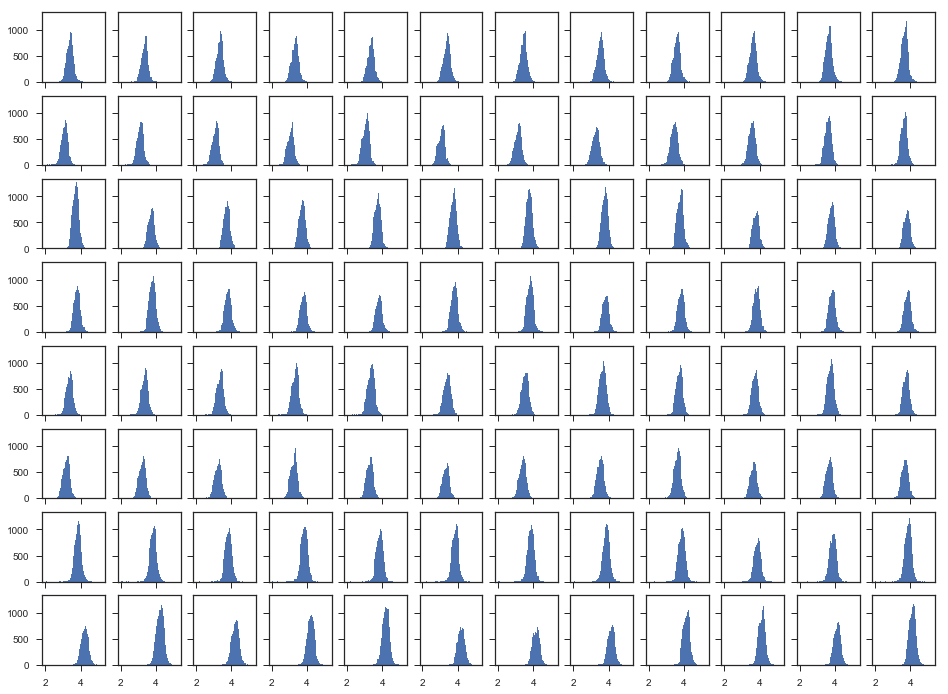

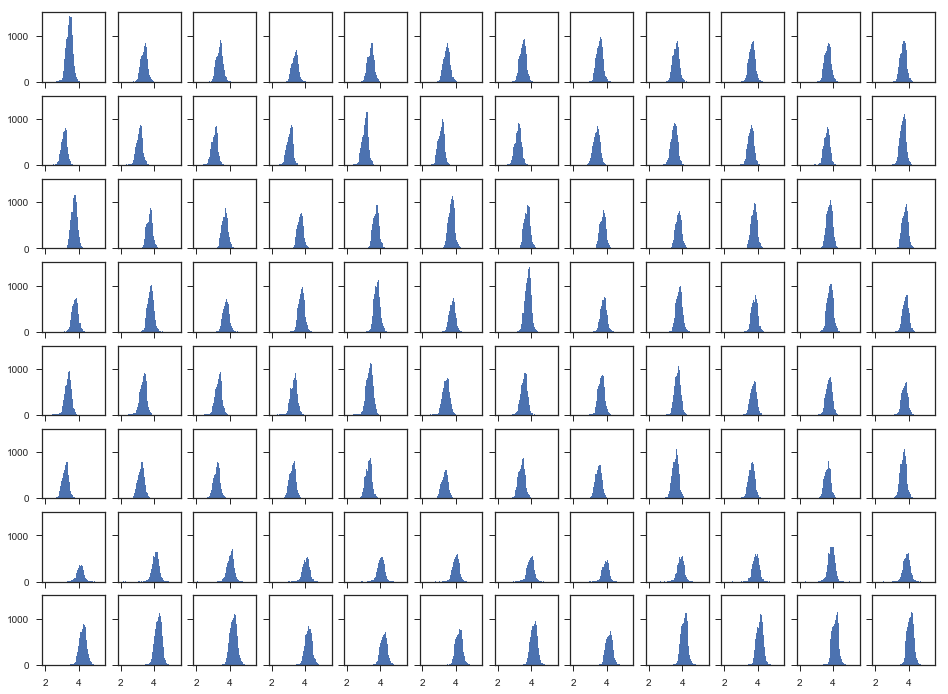

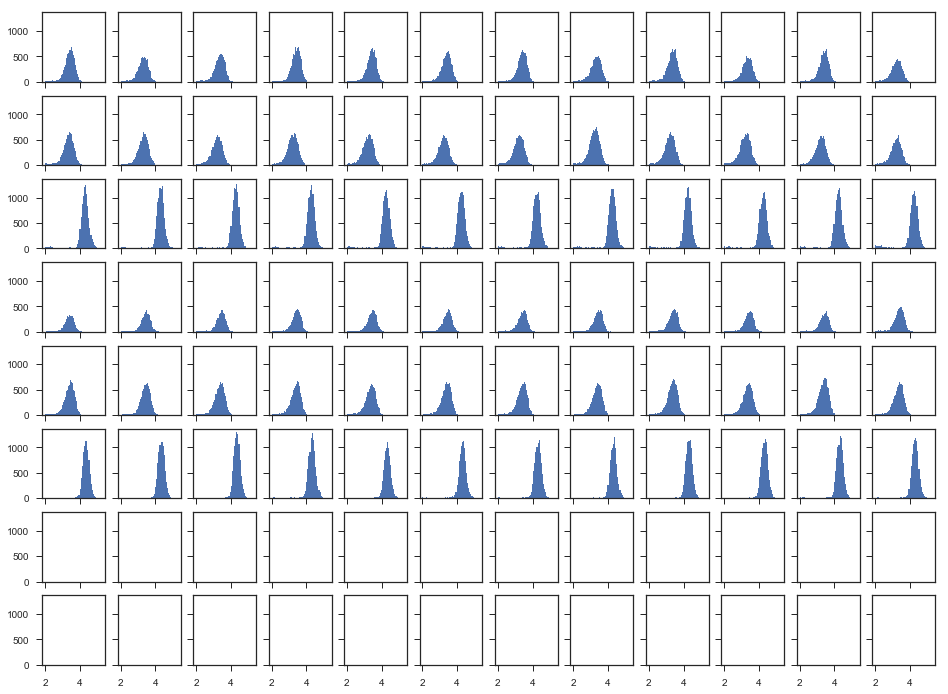

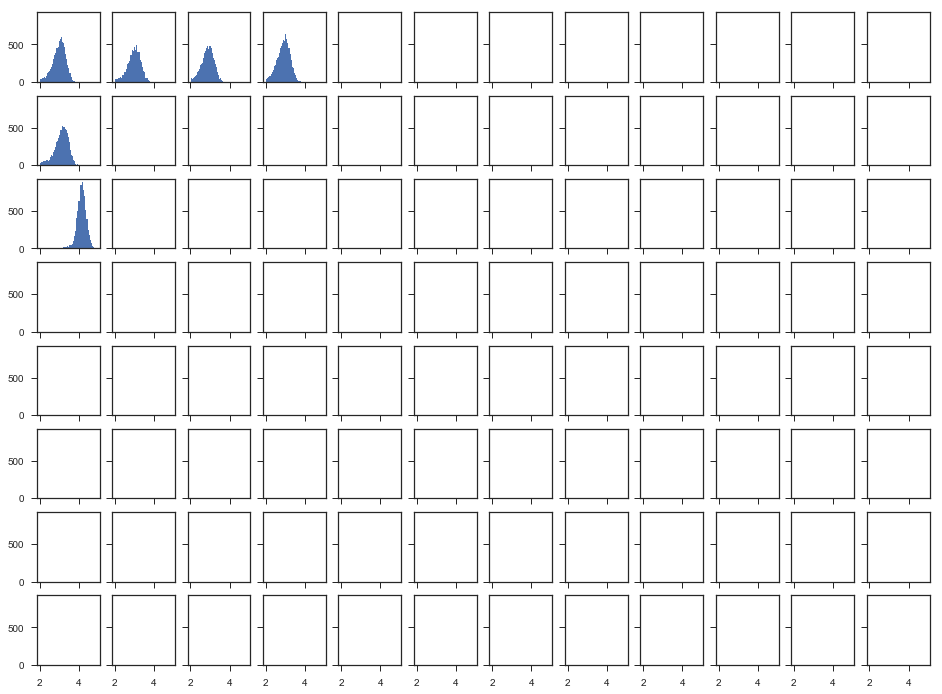

In [37]:
for plate in strains:
    FITCclean = pd.DataFrame(index = rows, columns = cols)
    logFITCclean = pd.DataFrame(index = rows, columns = cols)

    for row in rows:
        for col in cols:
            try:
                FITCclean.loc[row,col] = cleandata(allplates[plate].loc[row,col].data['FITC-A'].values,100)
                logFITCclean.loc[row,col] = np.log10(cleandata(allplates[plate].loc[row,col].data['FITC-A'].values,100))
            except:
                continue

    FITC_bincenter = pd.DataFrame(index = rows, columns = cols)
    FITC_histy = pd.DataFrame(index = rows, columns = cols)

    fig, ax = plt.subplots(8, 12,sharex = True, sharey = True, figsize=(16,12))

    for i in range(8):
        for j in range(12):
            try:
                FITC_histy.iloc[i,j],FITC_bincenter.iloc[i,j] = ax[i,j].hist(logFITCclean.iloc[i,j][~np.isnan(logFITCclean.iloc[i,j])],50,normed=0)
            except:
                continue

    dest = date + plate + 'fullhist'
    plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
    plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()

# Store mean and sd in arrays

In [9]:
deg = pd.DataFrame(index=['YFP','BFP'], columns=cols)
deg_std = pd.DataFrame(index=['YFP','BFP'], columns=cols)

for c in cols:
    deg.set_value('YFP',c,np.mean([FITCnorm['Plate3'].avg.loc['B',c],FITCnorm['Plate4'].avg.loc['B',c],FITCnorm['Plate5'].avg.loc['B',c]]))
    deg_std.set_value('YFP',c,np.std([FITCnorm['Plate3'].avg.loc['B',c],FITCnorm['Plate4'].avg.loc['B',c],FITCnorm['Plate5'].avg.loc['B',c]]))
    
    deg.set_value('BFP',c,np.mean([BFPnorm['Plate3'].avg.loc['B',c],BFPnorm['Plate4'].avg.loc['B',c],BFPnorm['Plate5'].avg.loc['B',c]]))
    deg_std.set_value('BFP',c,np.std([BFPnorm['Plate3'].avg.loc['B',c],BFPnorm['Plate4'].avg.loc['B',c],BFPnorm['Plate5'].avg.loc['B',c]]))

/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':


In [10]:
short = pd.DataFrame(index=['YFP','BFP'], columns=cols)
short_std = pd.DataFrame(index=['YFP','BFP'], columns=cols)

for c in cols:
    short.set_value('YFP',c,np.mean([FITCnorm['Plate3'].avg.loc['F',c],FITCnorm['Plate4'].avg.loc['F',c],FITCnorm['Plate5'].avg.loc['F',c]]))
    short_std.set_value('YFP',c,np.std([FITCnorm['Plate3'].avg.loc['F',c],FITCnorm['Plate4'].avg.loc['F',c],FITCnorm['Plate5'].avg.loc['F',c]]))
    
    short.set_value('BFP',c,np.mean([BFPnorm['Plate3'].avg.loc['F',c],BFPnorm['Plate4'].avg.loc['F',c],BFPnorm['Plate5'].avg.loc['F',c]]))
    short_std.set_value('BFP',c,np.std([BFPnorm['Plate3'].avg.loc['F',c],BFPnorm['Plate4'].avg.loc['F',c],BFPnorm['Plate5'].avg.loc['F',c]]))

/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':


In [11]:
deg2 = pd.DataFrame(index=['YFP','BFP'], columns=cols)
deg2_std = pd.DataFrame(index=['YFP','BFP'], columns=cols)

for c in cols:
    deg2.set_value('YFP',c,np.mean([FITCnorm['yAHN851_1'].avg.loc['A',c],FITCnorm['yAHN851_2'].avg.loc['A',c],FITCnorm['yAHN851_3'].avg.loc['A',c]]))
    deg2_std.set_value('YFP',c,np.std([FITCnorm['yAHN851_1'].avg.loc['A',c],FITCnorm['yAHN851_2'].avg.loc['A',c],FITCnorm['yAHN851_3'].avg.loc['A',c]]))
    
    deg2.set_value('BFP',c,np.mean([BFPnorm['yAHN851_1'].avg.loc['A',c],BFPnorm['yAHN851_2'].avg.loc['A',c],BFPnorm['yAHN851_3'].avg.loc['A',c]]))
    deg2_std.set_value('BFP',c,np.std([BFPnorm['yAHN851_1'].avg.loc['A',c],BFPnorm['yAHN851_2'].avg.loc['A',c],BFPnorm['yAHN851_3'].avg.loc['A',c]]))

/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  """
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':


In [24]:
(deg.loc['YFP','01']-deg.loc['YFP','05'])/deg.loc['YFP','05']

0.13400890848545763

In [22]:
(deg2.loc['YFP','01']-deg2.loc['YFP','04'])/deg2.loc['YFP','04']

0.0364716309001114

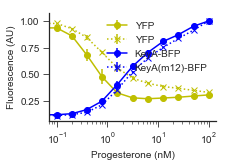

In [18]:
fig, ax1 = plt.subplots(figsize=(3,2))

ax1.errorbar(Px,deg.loc['YFP']/deg.loc['YFP','12'],yerr=deg_std.loc['YFP']/deg.loc['YFP','12'],fmt = 'o-', color = 'y',label = 'YFP')
ax1.errorbar(Px,short.loc['YFP']/short.loc['YFP','12'],yerr=short_std.loc['YFP']/short.loc['YFP','12'],fmt = 'x:', color = 'y',label = 'YFP')

ax1.errorbar(Px,deg.loc['BFP']/deg.loc['BFP','01'],yerr=deg_std.loc['BFP']/deg.loc['BFP','01'], fmt = 'o-',color = 'b',label = 'KeyA-BFP')
ax1.errorbar(Px,short.loc['BFP']/short.loc['BFP','01'],yerr=short_std.loc['BFP']/short.loc['BFP','01'], fmt = 'x:',color = 'b',label = 'KeyA(m12)-BFP')

ax1.set_ylabel('Fluorescence (AU)')
#ax1.set_yscale('log',basey=2)
ax1.set_xscale('log')
ax1.set_xlabel('Progesterone (nM)')
#ax1.set_xticklabels(rotation = 60)

#ax2.set_yscale('log',basey=2)

plt.legend()
sns.despine()

dest = date + 'degYRB'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
plt.show()
plt.close()

In [12]:
plateYFPavg = pd.DataFrame(index = rows, columns=cols)
plateYFPstd = pd.DataFrame(index = rows, columns=cols)

plateBFPavg = pd.DataFrame(index = rows, columns=cols)
plateBFPstd = pd.DataFrame(index = rows, columns=cols)

for r in rows:
    for c in cols:
        plateYFPavg.set_value(r,c,np.mean([FITCnorm['Plate3'].avg.loc[r,c],FITCnorm['Plate4'].avg.loc[r,c],FITCnorm['Plate5'].avg.loc[r,c]]))
        plateYFPstd.set_value(r,c,np.std([FITCnorm['Plate3'].avg.loc[r,c],FITCnorm['Plate4'].avg.loc[r,c],FITCnorm['Plate5'].avg.loc[r,c]]))

        plateBFPavg.set_value(r,c,np.mean([BFPnorm['Plate3'].avg.loc[r,c],BFPnorm['Plate4'].avg.loc[r,c],BFPnorm['Plate5'].avg.loc[r,c]]))
        plateBFPstd.set_value(r,c,np.std([BFPnorm['Plate3'].avg.loc[r,c],BFPnorm['Plate4'].avg.loc[r,c],BFPnorm['Plate5'].avg.loc[r,c]]))

/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if sys.path[0] == '':
/Users/andrewng/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]


In [13]:
strs = ['Full cODC, t9','no Pro, t12','no Pro, t9','CA only, t9','no Pro, t16','no Pro, t12 Key_m12','switchA, t9','bimSwitchA','t9']

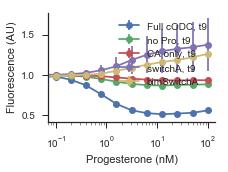

In [43]:
fig, ax1 = plt.subplots(figsize=(3,2))

rs = [0, 2, 3, 6, 7]

for x, i in enumerate(rs):
    ax1.errorbar(Px,plateYFPavg.iloc[i,:]/plateYFPavg.iloc[i,11],yerr=plateYFPstd.iloc[i,:]/plateYFPavg.iloc[i,11],fmt = 'o-',label = strs[i])
    #ax1.errorbar(Px,plateBFPavg.iloc[i,::-1]/plateBFPavg.iloc[i,11],yerr=plateBFPstd.iloc[i,::-1]/plateBFPavg.iloc[i,11],fmt = 'o-',label = strs[i])

ax1.set_ylabel('Fluorescence (AU)')
#ax1.set_yscale('log',basey=2)
ax1.set_xscale('log')
ax1.set_xlabel('Progesterone (nM)')
#ax1.set_xticklabels(rotation = 60)

#ax2.set_yscale('log',basey=2)

plt.legend()
sns.despine()

dest = date + 'cODCvarsY'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
plt.show()
plt.close()

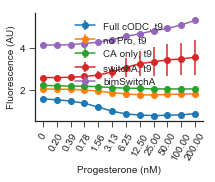

In [14]:
fig, ax1 = plt.subplots(figsize=(3,2))

rs = [0, 2, 3, 6, 7]

for x, i in enumerate(rs):
    ax1.errorbar(Pconcind,plateYFPavg.iloc[i,::-1],yerr=plateYFPstd.iloc[i,::-1],fmt = 'o-',label = strs[i])
    #ax1.errorbar(Px,plateBFPavg.iloc[i,::-1]/plateBFPavg.iloc[i,11],yerr=plateBFPstd.iloc[i,::-1]/plateBFPavg.iloc[i,11],fmt = 'o-',label = strs[i])

ax1.set_ylabel('Fluorescence (AU)')
#ax1.set_yscale('log',basey=2)
#ax1.set_xscale('log')
ax1.set_xticks(Pconcind)
ax1.set_xticklabels(Pconc[::-1],rotation = 60)
ax1.set_xlabel('Progesterone (nM)')
#ax1.set_xticklabels(rotation = 60)

#ax2.set_yscale('log',basey=2)

plt.legend()
sns.despine()

dest = date + 'cODCvarsYnonorm_fixed'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
plt.show()
plt.close()

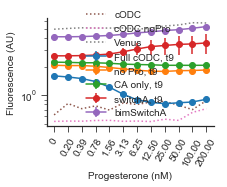

In [17]:
fig, ax1 = plt.subplots(figsize=(3,2))

rs = [0, 2, 3, 6, 7]

for x, i in enumerate(rs):
    ax1.errorbar(Pconcind,plateYFPavg.iloc[i,::-1],yerr=plateYFPstd.iloc[i,::-1],fmt = 'o-',label = strs[i])
    #ax1.errorbar(Px,plateBFPavg.iloc[i,::-1]/plateBFPavg.iloc[i,11],yerr=plateBFPstd.iloc[i,::-1]/plateBFPavg.iloc[i,11],fmt = 'o-',label = strs[i])

degstrs = ['cODC','cODC noPro','Venus']

for r in range(3):
    ax1.plot(Pconcind,FITCnorm['Plate6'].avg.iloc[r,::-1], ':',label = degstrs[r])
    #ax1.errorbar(Px,plateBFPavg.iloc[i,::-1]/plateBFPavg.iloc[i,11],yerr=plateBFPstd.iloc[i,::-1]/plateBFPavg.iloc[i,11],fmt = 'o-',label = strs[i])
    
ax1.set_ylabel('Fluorescence (AU)')
ax1.set_yscale('log')
#ax1.set_xscale('log')
ax1.set_xticks(Pconcind)
ax1.set_xticklabels(Pconc[::-1],rotation = 60)
ax1.set_xlabel('Progesterone (nM)')
#ax1.set_xticklabels(rotation = 60)

#ax2.set_yscale('log',basey=2)

plt.legend()
sns.despine()

dest = date + 'cODCvarsYnonorm_fixed'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
plt.show()
plt.close()

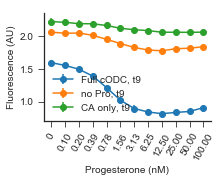

In [28]:
fig, ax1 = plt.subplots(figsize=(3,2))

rs = [0, 2, 3]

for x, i in enumerate(rs):
    ax1.errorbar(Pconcind,plateYFPavg.iloc[i,::-1],yerr=plateYFPstd.iloc[i,::-1],fmt = 'o-',label = strs[i])
    #ax1.errorbar(Px,plateBFPavg.iloc[i,::-1]/plateBFPavg.iloc[i,11],yerr=plateBFPstd.iloc[i,::-1]/plateBFPavg.iloc[i,11],fmt = 'o-',label = strs[i])

#degstrs = ['cODC','cODC noPro','Venus']

#for r in range(3):
#    ax1.plot(Px,FITCnorm['Plate6'].avg.iloc[r,:], ':',label = degstrs[r])
#    #ax1.errorbar(Px,plateBFPavg.iloc[i,::-1]/plateBFPavg.iloc[i,11],yerr=plateBFPstd.iloc[i,::-1]/plateBFPavg.iloc[i,11],fmt = 'o-',label = strs[i])
    
ax1.set_ylabel('Fluorescence (AU)')
#ax1.set_yscale('log',basey=2)
#ax1.set_xscale('log')
ax1.set_xticks(Pconcind)
ax1.set_xticklabels(Pconc[::-1],rotation = 60)
ax1.set_xlabel('Progesterone (nM)')
#ax1.set_xticklabels(rotation = 60)

#ax2.set_yscale('log',basey=2)

plt.legend()
sns.despine()

dest = date + 'cODCvarsYnonorm'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
plt.show()
plt.close()

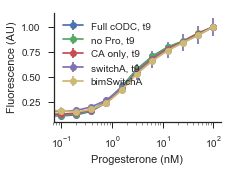

In [48]:
fig, ax1 = plt.subplots(figsize=(3,2))

rs = [0, 2, 3, 6, 7]

for x, i in enumerate(rs):
    #ax1.errorbar(Px,plateYFPavg.iloc[i,:]/plateYFPavg.iloc[i,11],yerr=plateYFPstd.iloc[i,:]/plateYFPavg.iloc[i,11],fmt = 'o-',label = strs[i])
    ax1.errorbar(Px,plateBFPavg.iloc[i,:]/plateBFPavg.iloc[i,0],yerr=plateBFPstd.iloc[i,:]/plateBFPavg.iloc[i,0],fmt = 'o-',label = strs[i])

ax1.set_ylabel('Fluorescence (AU)')
#ax1.set_yscale('log',basey=2)
ax1.set_xscale('log')
ax1.set_xlabel('Progesterone (nM)')
#ax1.set_xticklabels(rotation = 60)

#ax2.set_yscale('log',basey=2)

plt.legend()
sns.despine()

dest = date + 'cODCvarsB'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
plt.show()
plt.close()

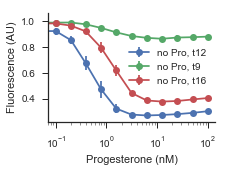

In [61]:
fig, ax1 = plt.subplots(figsize=(3,2))

rs = [1,2,4]

for x, i in enumerate(rs):
    ax1.errorbar(Px,plateYFPavg.iloc[i,:]/plateYFPavg.iloc[i,11],yerr=plateYFPstd.iloc[i,:]/plateYFPavg.iloc[i,11],fmt = 'o-',label = strs[i])
    #ax1.errorbar(Px,plateBFPavg.iloc[i,:],yerr=plateBFPstd.iloc[i,:],fmt = 'o-',label = strs[i])

ax1.set_ylabel('Fluorescence (AU)')
#ax1.set_yscale('log',basey=2)
ax1.set_xscale('log')
ax1.set_xlabel('Progesterone (nM)')
#ax1.set_xticklabels(rotation = 60)

#ax2.set_yscale('log',basey=2)

plt.legend()
sns.despine()

dest = date + 'noProvarsYnorm'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
plt.show()
plt.close()

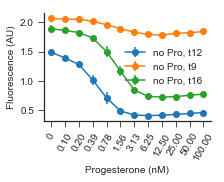

In [29]:
fig, ax1 = plt.subplots(figsize=(3,2))

rs = [1,2,4]

for x, i in enumerate(rs):
    ax1.errorbar(Pconcind,plateYFPavg.iloc[i,::-1],yerr=plateYFPstd.iloc[i,::-1],fmt = 'o-',label = strs[i])
    #ax1.errorbar(Px,plateBFPavg.iloc[i,:],yerr=plateBFPstd.iloc[i,:],fmt = 'o-',label = strs[i])

ax1.set_ylabel('Fluorescence (AU)')
#ax1.set_yscale('log',basey=2)
#ax1.set_xscale('log')
ax1.set_xticks(Pconcind)
ax1.set_xticklabels(Pconc[::-1],rotation = 60)
ax1.set_xlabel('Progesterone (nM)')
#ax1.set_xticklabels(rotation = 60)

#ax2.set_yscale('log',basey=2)

plt.legend()
sns.despine()

dest = date + 'noProvarsYnonorm'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
plt.show()
plt.close()

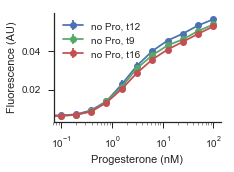

In [63]:
fig, ax1 = plt.subplots(figsize=(3,2))

rs = [1,2,4]

for x, i in enumerate(rs):
    #ax1.errorbar(Px,plateYFPavg.iloc[i,:]/plateYFPavg.iloc[i,11],yerr=plateYFPstd.iloc[i,:]/plateYFPavg.iloc[i,11],fmt = 'o-',label = strs[i])
    ax1.errorbar(Px,plateBFPavg.iloc[i,:],yerr=plateBFPstd.iloc[i,:],fmt = 'o-',label = strs[i])

ax1.set_ylabel('Fluorescence (AU)')
#ax1.set_yscale('log',basey=2)
ax1.set_xscale('log')
ax1.set_xlabel('Progesterone (nM)')
#ax1.set_xticklabels(rotation = 60)

#ax2.set_yscale('log',basey=2)

plt.legend()
sns.despine()

dest = date + 'cODCvarsBnonorm'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
plt.show()
plt.close()

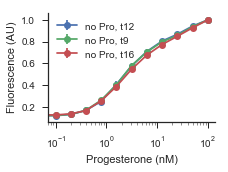

In [64]:
fig, ax1 = plt.subplots(figsize=(3,2))

rs = [1,2,4]

for x, i in enumerate(rs):
    #ax1.errorbar(Px,plateYFPavg.iloc[i,:]/plateYFPavg.iloc[i,11],yerr=plateYFPstd.iloc[i,:]/plateYFPavg.iloc[i,11],fmt = 'o-',label = strs[i])
    ax1.errorbar(Px,plateBFPavg.iloc[i,:]/plateBFPavg.iloc[i,0],yerr=plateBFPstd.iloc[i,:]/plateBFPavg.iloc[i,0],fmt = 'o-',label = strs[i])

ax1.set_ylabel('Fluorescence (AU)')
#ax1.set_yscale('log',basey=2)
ax1.set_xscale('log')
ax1.set_xlabel('Progesterone (nM)')
#ax1.set_xticklabels(rotation = 60)

#ax2.set_yscale('log',basey=2)

plt.legend()
sns.despine()

dest = date + 'cODCvarsBnonorm'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
plt.show()
plt.close()

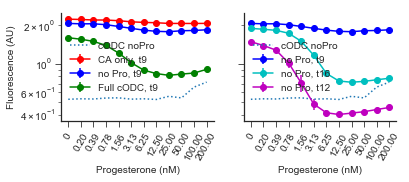

In [20]:
fig, ax = plt.subplots(1,2,sharey=True,figsize=(6,2))

ax[0].errorbar(Pconcind,plateYFPavg.iloc[3,::-1],yerr=plateYFPstd.iloc[3,::-1],color = 'r', fmt = 'o-',label = strs[3])
ax[0].errorbar(Pconcind,plateYFPavg.iloc[2,::-1],yerr=plateYFPstd.iloc[2,::-1],color = 'b', fmt = 'o-',label = strs[2])
ax[0].errorbar(Pconcind,plateYFPavg.iloc[0,::-1],yerr=plateYFPstd.iloc[0,::-1],color = 'g', fmt = 'o-',label = strs[0])

ax[1].errorbar(Pconcind,plateYFPavg.iloc[2,::-1],yerr=plateYFPstd.iloc[2,::-1],color = 'b', fmt = 'o-',label = strs[2])
ax[1].errorbar(Pconcind,plateYFPavg.iloc[4,::-1],yerr=plateYFPstd.iloc[4,::-1],color = 'c', fmt = 'o-',label = strs[4])
ax[1].errorbar(Pconcind,plateYFPavg.iloc[1,::-1],yerr=plateYFPstd.iloc[1,::-1],color = 'm', fmt = 'o-',label = strs[1])

ax[0].plot(Pconcind,FITCnorm['Plate6'].avg.iloc[1,::-1], ':',label = degstrs[1])
ax[1].plot(Pconcind,FITCnorm['Plate6'].avg.iloc[1,::-1], ':',label = degstrs[1])

ax[0].set_ylabel('Fluorescence (AU)')
ax[0].set_yscale('log')

for i in range(2):
    ax[i].set_xticks(Pconcind)
    ax[i].set_xticklabels(Pconc[::-1],rotation = 60)
    ax[i].set_xlabel('Progesterone (nM)')
#ax1.set_xticklabels(rotation = 60)

ax[0].legend()
ax[1].legend()

sns.despine()

dest = date + 'allvarsYnonorm_fixed'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
plt.show()
plt.close()